In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cv2
from PIL import Image
import glob
import os
import re
from numba import cuda

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, RepeatVector, LSTM, TimeDistributed,MaxPooling2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error

In [2]:
images_folder = 'images2/'

In [3]:
image_paths = glob.glob(os.path.join(images_folder, '*.png'))
sorted_list = sorted(image_paths, key=lambda x: int(re.search(r'image(\d+)_Tair', x).group(1)))

In [4]:
def rescale_image_to_array(files, target_size=(30, 30)):
    array = []
    for file in files:
        img = Image.open(file).convert('RGB').resize(target_size) 
        array.append(np.array(img))
    return np.array(array)

In [5]:
# def load_images_from_directory(files, target_size=(128, 128)):
#     images = []
#     for filename in files:
#         img = image.load_img(filename, target_size=target_size)
#         img_array = image.img_to_array(img)
#         images.append(img_array)   
#     return np.array(images)

In [6]:
images = rescale_image_to_array(sorted_list)

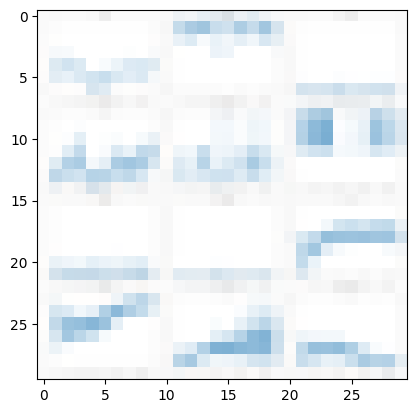

In [7]:
plt.imshow(images[0])
plt.show()

In [8]:
images.shape

(2497, 30, 30, 3)

In [9]:
from sklearn.metrics import r2_score

In [10]:
target = pd.read_csv('dataset_tout_rounded.csv')

In [11]:
target = target.to_numpy()

In [12]:
target.shape

(2497, 168)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    images,  
    target,       
    test_size=0.2,    
    random_state=50,  
    shuffle=True      
)

In [14]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [15]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [16]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def create_model(num_conv_layers=2, filter_sizes=[32, 64, 64], kernel_size=(3,3),
                input_shape=(30,30,3), dense_units=64*64, dropout_rate=0.5):
    model = models.Sequential()
    
    model.add(layers.Conv2D(filter_sizes[0], kernel_size, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    for i in range(1, num_conv_layers):
        model.add(layers.Conv2D(filter_sizes[i], kernel_size, activation='relu', padding='SAME'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(168))  

    model.compile(optimizer=Adam(0.0001), loss='mean_squared_error', metrics=['mae'])
    
    return model

In [17]:
results = []

In [18]:
filters = [32, 64, 64, 128]
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
num_layers = 1
for filter_size in filters:
        model = create_model(filter_sizes=filters,num_conv_layers=num_layers)
        history = model.fit(
                X_train, y_train,
                epochs=100,
                batch_size=16,  
                validation_data=(X_test, y_test),
                callbacks=[early_stopping]
        )
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        r2_test = r2_score(y_test, y_pred)
        r2_train = r2_score(y_train, y_pred_train)
        results.append((r2_train,r2_test, num_layers, model,history))
        num_layers += 1

Epoch 1/100
125/125 [==============================] - 7s 11ms/step - loss: 0.7022 - mae: 0.6404 - val_loss: 0.9553 - val_mae: 0.7250
Epoch 2/100
125/125 [==============================] - 1s 8ms/step - loss: 0.5525 - mae: 0.5703 - val_loss: 0.8911 - val_mae: 0.7038
Epoch 3/100
125/125 [==============================] - 1s 8ms/step - loss: 0.5110 - mae: 0.5446 - val_loss: 0.7588 - val_mae: 0.6557
Epoch 4/100
125/125 [==============================] - 1s 8ms/step - loss: 0.4855 - mae: 0.5284 - val_loss: 0.6205 - val_mae: 0.6050
Epoch 5/100
125/125 [==============================] - 1s 7ms/step - loss: 0.4651 - mae: 0.5158 - val_loss: 0.5204 - val_mae: 0.5615
Epoch 6/100
125/125 [==============================] - 1s 7ms/step - loss: 0.4520 - mae: 0.5069 - val_loss: 0.4608 - val_mae: 0.5230
Epoch 7/100
125/125 [==============================] - 1s 7ms/step - loss: 0.4367 - mae: 0.4974 - val_loss: 0.4376 - val_mae: 0.5032
Epoch 8/100
125/125 [==============================] - 1s 7ms/step -

In [19]:
results

[(0.9039911747289424,
  0.8733150821728193,
  1,
  <keras.callbacks.History at 0x24f5218bfd0>),
 (0.8441699198315068,
  0.8190630080502359,
  2,
  <keras.callbacks.History at 0x24f5406acd0>),
 (0.9189596315991928,
  0.8938600856581683,
  3,
  <keras.callbacks.History at 0x24f6c335ee0>),
 (0.8883122246697739,
  0.8642404942572539,
  4,
  <keras.callbacks.History at 0x24f93ad7160>)]

In [33]:
history = results[2][4]
model = results[2][3]

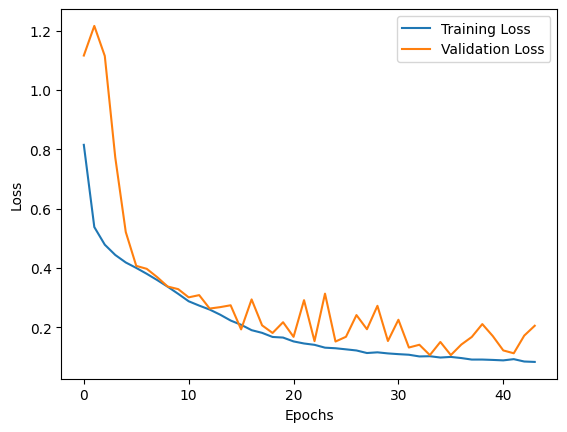

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
with tf.device('/CPU:0'):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

16/16 [==============================] - 0s 9ms/step


In [37]:
print("R2 score for training data:", r2_score(y_train, y_pred_train))
print("R2 score for testing data:", r2_score(y_test, y_pred_test))

R2 score for training data: 0.9189577166962062
R2 score for testing data: 0.893854777710118


In [38]:
print("MSE score for testing data:", mean_squared_error(y_train, y_pred_train))
print("MAE score for testing data:", mean_absolute_error(y_test, y_pred_test))

MSE score for testing data: 0.08104228330379383
MAE score for testing data: 0.2408074299495535


In [39]:
model.save('models\model_tout_0.h5')

In [40]:
y_pred_test_true = scaler.inverse_transform(y_pred_test)
y_test_true = scaler.inverse_transform(y_test)

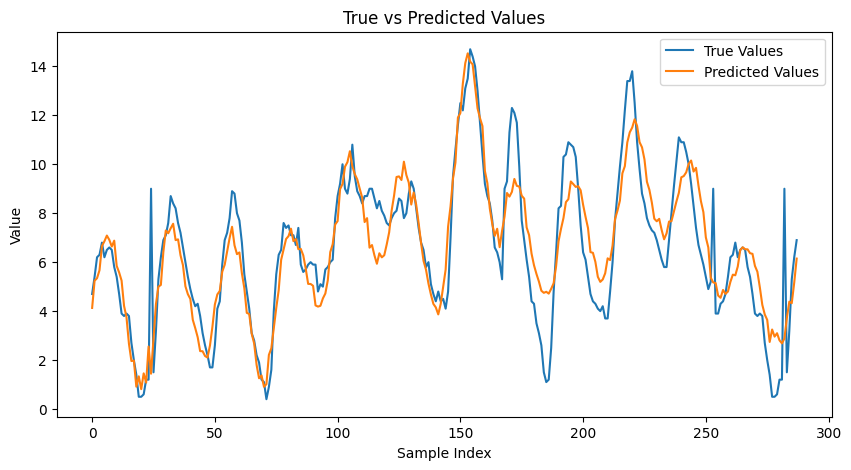

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_true.flatten()[:288], label='True Values')
plt.plot(y_pred_test_true.flatten()[:288], label='Predicted Values')
plt.xlabel('Sample Index')
plt.title('True vs Predicted Values')
plt.ylabel('Value')
plt.legend()
plt.show()

# Visualize CONVS

In [42]:
from tensorflow.keras.models import load_model
model = load_model('models/model_tout_0.h5')

In [43]:
for layer in model.layers:
    print(layer.name)

conv2d_3
batch_normalization_3
max_pooling2d_3
conv2d_4
batch_normalization_4
max_pooling2d_4
conv2d_5
batch_normalization_5
max_pooling2d_5
flatten_2
dense_4
dropout_2
dense_5


1/1 [==============================] - 0s 31ms/step


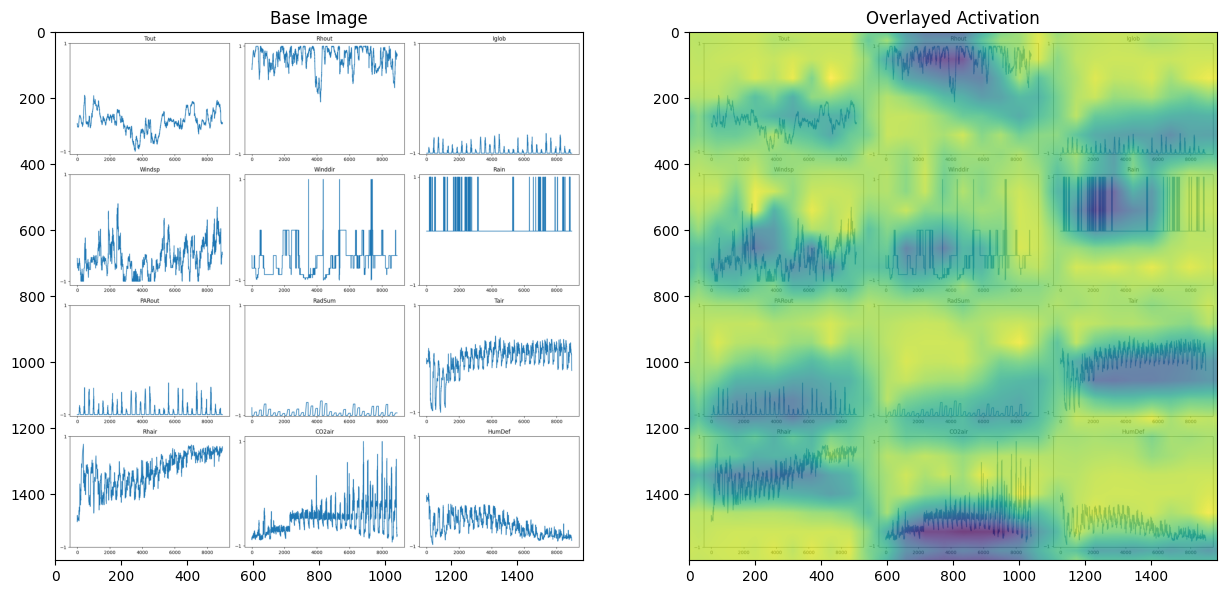

In [47]:
from skimage.transform import resize

input1 = X_test[0]
layer_name = 'conv2d_3' 
layer = model.get_layer(layer_name)

activation_model = Model(inputs=model.input, outputs=layer.output)
image_input = np.expand_dims(input1, axis=0)
activations = activation_model.predict(image_input)

activa = activations[0, :, :, 3]
activa_rescaled = resize(activa, (1600, 1600), anti_aliasing=True)
input1 = rescale_image_to_array([sorted_list[0]],(1600,1600))[0]
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(input1)
ax[0].set_title('Base Image')
ax[1].imshow(input1)
ax[1].imshow(activa_rescaled, cmap='viridis', alpha=0.75)
ax[1].set_title('Overlayed Activation')
plt.show()